<h1 align=center>Roboflow dataset</h1>

In [107]:
import os #type: ignore
import cv2 #type: ignore
import numpy as np #type: ignore
import matplotlib.pyplot as plt #type: ignore
import matplotlib.patches as patches
import tensorflow as tf #type: ignore

from sklearn.preprocessing import LabelEncoder #type: ignore
from tensorflow.keras.applications import VGG16 #type: ignore
from tensorflow.keras.models import Model #type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras import regularizers #type: ignore
from tensorflow.keras import layers #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore


In [82]:
train_folder = 'Data/Human.v1i.yolov11/train/'
valid_folder = 'Data/Human.v1i.yolov11/valid/'
test_folder = 'Data/Human.v1i.yolov11/test/'

In [108]:
def plot_img_with_box(data_dir, file_title, title="Image with Bounding Box", figsize=(8, 8)):
    """
    Plots an image with its bounding box from a dataset directory.
    
    Args:
        data_dir (str): Path to the dataset directory containing 'images' and 'labels'.
        file_title (str): The name of the image file (e.g., 'img1.jpg').
        title (str): Title of the plot.
        figsize (tuple): Size of the figure.
    """
    # Paths for the image and label
    image_path = os.path.join(data_dir, 'images', file_title)
    label_path = os.path.join(data_dir, 'labels', file_title.replace('.jpg', '.txt'))
    
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img_height, img_width, _ = image.shape

    # Read the bounding box label
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
    else:
        lines = []  # No label file
    
    # Parse the first bounding box (for simplicity)
    if lines:
        line = lines[0]  # Use the first bounding box
        _, x_center, y_center, width, height = map(float, line.split())
        x_min = int((x_center - width / 2) * img_width)
        y_min = int((y_center - height / 2) * img_height)
        x_max = int((x_center + width / 2) * img_width)
        y_max = int((y_center + height / 2) * img_height)
    else:
        # No bounding box, assign defaults
        x_min, y_min, x_max, y_max = 0, 0, 0, 0

    # Create a plot
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)
    
    # Add bounding box as a rectangle
    if lines:  # Only draw if a bounding box exists
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    
    # Set title and axis
    ax.set_title(title)
    ax.axis('off')
    plt.show()

def parse_label(label_path, img_width, img_height):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    bounding_boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        # Normalize coordinates to [0, 1]
        x_min = (x_center - width / 2)
        y_min = (y_center - height / 2)
        x_max = (x_center + width / 2)
        y_max = (y_center + height / 2)
        
        bounding_boxes.append([x_min, y_min, x_max, y_max])  # Only bounding box coordinates
    return np.array(bounding_boxes, dtype=np.float32)

def load_data(dir):
    image_dir = os.path.join(dir, 'images')
    label_dir = os.path.join(dir, 'labels')
    image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')])
    label_paths = sorted([os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir) if lbl.endswith('.txt')])

    images = []
    class_labels = []
    bbox_labels = []
    
    for img_path, lbl_path in zip(image_paths, label_paths):
        # Load image
        img = cv2.imread(img_path)
        img_height, img_width, _ = img.shape

        # Parse label
        bboxes = parse_label(lbl_path, img_width, img_height)
        
        # Resize and normalize image
        img = cv2.resize(img, (224, 224))  # Resize to input size
        img = img / 255.0  # Normalize to [0, 1]
        
        if bboxes.size == 0:  # No bounding boxes
            class_label = 0.0  # No object
            bboxes = [[0.0, 0.0, 0.0, 0.0]]  # Default bounding box
        else:
            class_label = 1.0  # Object present
        
        images.append(img)
        class_labels.append(class_label)
        bbox_labels.append(bboxes[0])  # Use the first bounding box for simplicity

    return np.array(images, dtype=np.float32), np.array(class_labels, dtype=np.float32), np.array(bbox_labels, dtype=np.float32)


def create_tf_dataset(images, class_labels, bbox_labels, batch_size):
    def preprocess(image, labels):
        class_label = labels["class_output"]
        bbox_label = labels["bbox_output"]

        # Convert to tensors
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        class_label = tf.convert_to_tensor(class_label, dtype=tf.float32)
        bbox_label = tf.convert_to_tensor(bbox_label, dtype=tf.float32)

        return image, {"class_output": class_label, "bbox_output": bbox_label}
    
    # Create dictionary of labels
    labels = {
        "class_output": class_labels,
        "bbox_output": bbox_labels
    }
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



In [85]:
BATCH_SIZE = 16

train_images, train_class_labels, train_bbox_labels = load_data(train_folder)
train_dataset = create_tf_dataset(train_images, train_class_labels, train_bbox_labels, BATCH_SIZE)

val_images, val_class_labels, val_bbox_labels = load_data(valid_folder)
val_dataset = create_tf_dataset(val_images, val_class_labels, val_bbox_labels, BATCH_SIZE)

test_images, test_class_labels, test_bbox_labels = load_data(test_folder)
test_dataset = create_tf_dataset(test_images, test_class_labels, test_bbox_labels, BATCH_SIZE)

<h2 align=center>Modeling</h2>

In [186]:
def cnn_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Outputs
    class_output = layers.Dense(1, activation='sigmoid', name='class_output')(x)  # Binary classification
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)  # Bounding box regression

    # Model
    model = Model(inputs=inputs, outputs=[class_output, bbox_output])
    return model

input_shape = (224, 224, 3)
model = cnn_model(input_shape)

In [187]:
input_shape = (224, 224, 3)
model = cnn_model(input_shape)
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 112, 112,  │          0 │ conv2d_53[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 112, 112,  │          0 │ max_pooling2d_47… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 112, 112,  │     18,496 │ dropout_35[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_48    │ (None, 56, 56,    │          0 │ conv2d_54[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 56, 56,    │          0 │ max_pooling2d_48… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 56, 56,    │     73,856 │ dropout_36[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_49    │ (None, 28, 28,    │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 28, 28,    │          0 │ max_pooling2d_49… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 28, 28,    │    295,168 │ dropout_37[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 14, 14,    │          0 │ conv2d_56[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 14, 14,    │          0 │ max_pooling2d_50… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 50176)     │          0 │ dropout_38[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │ 12,845,312 │ flatten_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 256)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 1)         │        257 │ dropout_39[0][0]  │
│ (Dense)             │                   │            │                 

 Total params: 13,235,013 (50.49 MB)

 Trainable params: 13,235,013 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
losses = {
    "class_output": "binary_crossentropy",  # Binary classification
    "bbox_output": "mse",  # Bounding box regression
}

loss_weights = {
    "class_output": 1.0,  # Weight for classification loss
    "bbox_output": 2.0,  # Weight for bounding box regression
}

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    optimizer=opt,
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        "class_output": "accuracy",  # Monitor classification accuracy
        "bbox_output": "mse",       # Monitor bounding box regression error
    }
)


In [193]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=10,
    batch_size=16
)

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - bbox_output_mse: 0.0759 - class_output_accuracy: 0.9162 - loss: 0.4192 - val_bbox_output_mse: 0.0455 - val_class_output_accuracy: 0.9716 - val_loss: 0.2262
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - bbox_output_mse: 0.0752 - class_output_accuracy: 0.9148 - loss: 0.3369 - val_bbox_output_mse: 0.0458 - val_class_output_accuracy: 0.9716 - val_loss: 0.2242
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - bbox_output_mse: 0.0746 - class_output_accuracy: 0.9159 - loss: 0.3172 - val_bbox_output_mse: 0.0468 - val_class_output_accuracy: 0.9716 - val_loss: 0.2291
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - bbox_output_mse: 0.0733 - class_output_accuracy: 0.9157 - loss: 0.3268 - val_bbox_output_mse: 0.0465 - val_class_output_accuracy: 0.9716 - val_loss: 0.2336
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - bbox_output_mse: 0.0718 - class_output_accuracy: 0.9158 - loss: 0.3157 - val_bbox_output_mse: 0.

In [ ]:
model.save_weights('model_weights2_wiht_conv256_no_dropout.weights.h5')

In [195]:
model.evaluate(test_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - bbox_output_mse: 0.0460 - class_output_accuracy: 0.9398 - loss: 0.2307


[0.20802459120750427, 0.040677085518836975, 0.9715909361839294]

In [61]:
def predict_and_plot(model, image_path, threshold=0.8):
    # Load the image
    img = cv2.imread(image_path)
    original_height, original_width = img.shape[:2]  # Extract original dimensions
    
    # Preprocess the image
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize
    img_input = img_resized[np.newaxis, ...]  # Add batch dimension

    # Make predictions
    class_pred, bbox_pred = model.predict(img_input)
    class_pred = class_pred[0]  # Extract the first sample (batch size = 1)
    bbox_pred = bbox_pred[0]  # Extract the first sample (batch size = 1)

    # Postprocess predictions
    if class_pred >= threshold:
        # Denormalize bounding box to original dimensions
        x_min = int(bbox_pred[0] * original_width)
        y_min = int(bbox_pred[1] * original_height)
        x_max = int(bbox_pred[2] * original_width)
        y_max = int(bbox_pred[3] * original_height)

        # Plot the image with bounding box
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          linewidth=2, edgecolor='g', facecolor='none'))
        plt.title(f"Predicted: {'Object Present' if class_pred >= threshold else 'No Object'}")
        plt.show()
    else:
        print("No object detected.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


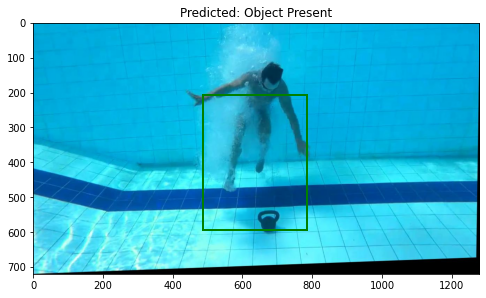

In [194]:
image_path = '/Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/Human.v1i.yolov11/train/images/ezgif-frame-002_jpg.rf.e6719eaa2de523eec0df2c6955bfbd54.jpg'
predict_and_plot(model, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


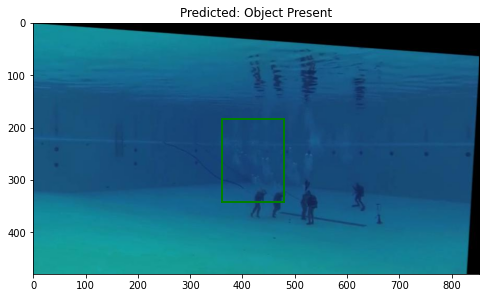

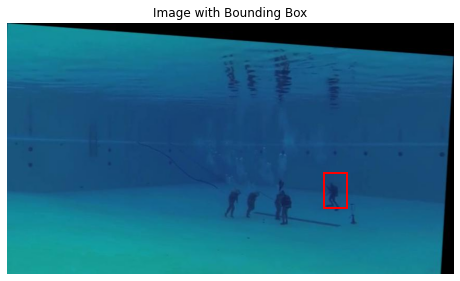

In [196]:
img_name = '681_jpg.rf.3d3078756c0047225f83db410fe1e1b5.jpg'
image_path = os.path.join(train_folder, 'images', img_name)

predict_and_plot(model, image_path)
plt.show()

plot_img_with_box(train_folder, img_name)
plt.show()

In [79]:
import cv2
import numpy as np
import tensorflow as tf

def process_video_stream(model, video_source=0, threshold=0.5):
    """
    Process a video stream and use the model to predict and display bounding boxes.

    Args:
        model: Trained TensorFlow/Keras model.
        video_source: Video source, 0 for webcam, or path to a video file.
        threshold: Confidence threshold for detecting objects.
    """
    # Open video source (webcam or video file)
    cap = cv2.VideoCapture(video_source)

    if not cap.isOpened():
        print("Error: Unable to access the video source.")
        return

    while True:
        # Read a frame
        ret, frame = cap.read()
        if not ret:
            print("End of video stream.")
            break

        # Get original dimensions
        original_height, original_width = frame.shape[:2]

        # Preprocess the frame
        img_resized = cv2.resize(frame, (224, 224)) / 255.0
        img_input = img_resized[np.newaxis, ...]  # Add batch dimension

        # Make predictions
        class_pred, bbox_pred = model.predict(img_input)
        class_pred = class_pred[0]  # Extract the first sample
        bbox_pred = bbox_pred[0]  # Extract the first sample

        # Postprocess predictions
        if class_pred >= threshold:
            # Denormalize bounding box to original dimensions
            x_min = int(bbox_pred[0] * original_width)
            y_min = int(bbox_pred[1] * original_height)
            x_max = int(bbox_pred[2] * original_width)
            y_max = int(bbox_pred[3] * original_height)

            # Draw bounding box
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(frame, f"Object Detected {class_pred}", (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the frame
        cv2.imshow("Video Stream", frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()


In [168]:
process_video_stream(model, threshold=0.95)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

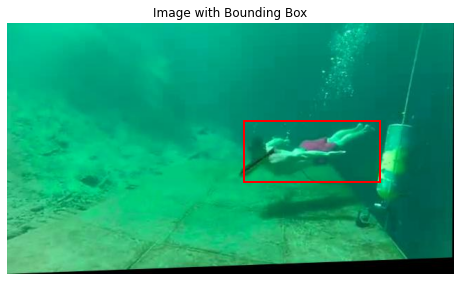

In [ ]:

import os
import cv2
import matplotlib.pyplot as plt






In [ ]:

img = image.load_img(image_path)
img_array = image.img_to_array(img)
img_array.shape

img_conv = cv2.imread(image_path)
_, x_min, y_min, x_max, y_max = box

pt1 = (int(x_min), int(y_min))
pt2 = (int(x_max), int(y_max))
cv2.rectangle(img_conv, pt1, pt2, (0, 255, 2), 2)

plt.imshow(cv2.cvtColor(img_conv, cv2.COLOR_RGB2BGR))

plt.show()
